# Binary Classification

# Loading the Dataset
***

The dataset consists of ecological data collected from Penguins living in Antarctica. The data were made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

The goal is to correctly identify Chinstrap Penguin species based on the following attributes:

- sex: penguin sex (Male or Female)
- island: name of the island (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica) where the observation was made
- body_mass_g: body mass (g)
- flipper_length_mm: flipper length (mm)
- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)

*Note: the culmen is "the upper ridge of a bird's beak"*

The dataset is provided as the file `2022-a1-penguin-classification.csv` alongside this notebook. 

In [2]:
## setup notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
%matplotlib inline

In [3]:
df_penguin_data = pd.read_csv("./2022-a1-penguin-classification.csv")
df_penguin_data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
# convert data to a binary classification problem
df_penguin_data["is_chinstrap"] = np.where((df_penguin_data["species"] == 'Chinstrap'),1, 0)
df_penguin_data = df_penguin_data.drop(columns=["species"], errors="ignore")

### Exploratory Data Analysis (EDA)

#### Distribution of data in the target class

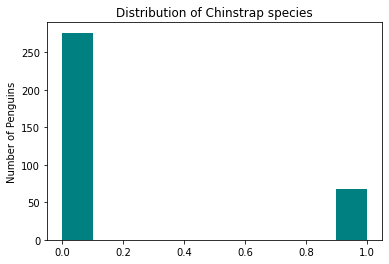

In [5]:
ax = df_penguin_data["is_chinstrap"].hist(grid=False, color="teal") # plot histogram of target class
ax.set_ylabel("Number of Penguins")
ax.set_title("Distribution of Chinstrap species");

There is class imbalance in the distribution of the Penguin species which will affect the performance of the classifier. 

 #### Correlations between your numerical attributes and your target variable

In [27]:
# correlation matrix
corr_matrix = df_penguin_data.corr()
corr_matrix["is_chinstrap"].sort_values(ascending=False)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,is_chinstrap
culmen_length_mm,1.000000,-0.240538,0.647875,0.586736,0.453900
culmen_depth_mm,-0.240538,1.000000,-0.589735,-0.487264,0.320601
flipper_length_mm,0.647875,-0.589735,1.000000,0.872848,-0.188121
body_mass_g,0.586736,-0.487264,0.872848,1.000000,-0.297013
is_chinstrap,0.453900,0.320601,-0.188121,-0.297013,1.000000


The most important feature for identifying a Chinstrap penguin is the length of the culmen. A Chinstrap penguin will likely have longer culmen and smaller body mass compared to other penguins.

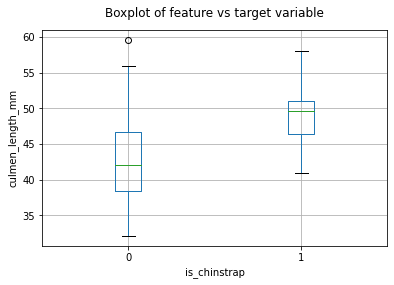

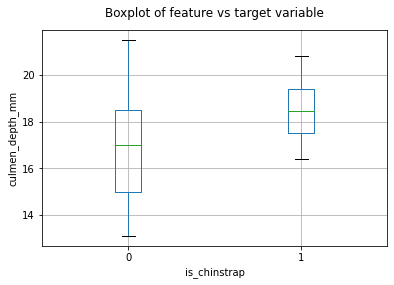

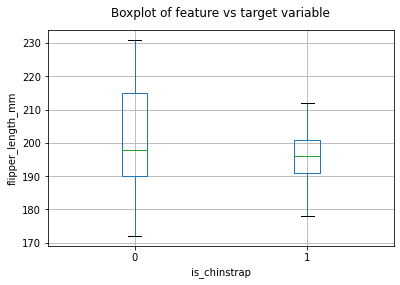

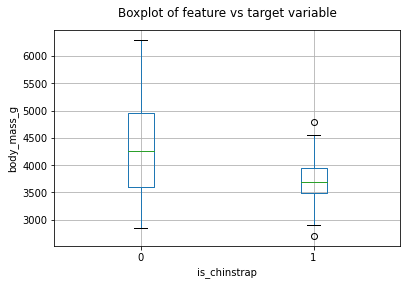

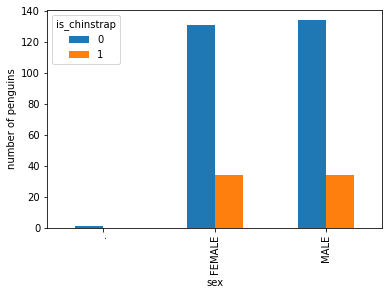

In [7]:
# function to make boxplot for the features
def viz(data,attr, target):
    ax = data.boxplot(attr,target) 
    ax.set_title(" ")
    ax.get_figure().suptitle("Boxplot of feature vs target variable")
    ax.set_ylabel(attr)

features = ["culmen_length_mm","culmen_depth_mm","flipper_length_mm","body_mass_g","sex"]
for item in features:
    if item == "sex":
        CrosstabResult=pd.crosstab(index=df_penguin_data['sex'],columns=df_penguin_data['is_chinstrap'])
        CrosstabResult.plot.bar(ylabel="number of penguins")
    else:
        viz(df_penguin_data,item,"is_chinstrap")

#### Handling outliers

In [8]:
# code to identify outliers based on the boxplot 
outlier1 = df_penguin_data[(df_penguin_data['culmen_length_mm'] >58) & (df_penguin_data['is_chinstrap'] == 0)]
outlier2 = df_penguin_data[(df_penguin_data['body_mass_g'] >4700) & (df_penguin_data['is_chinstrap'] == 1)]
outlier3 = df_penguin_data[(df_penguin_data['body_mass_g'] < 2800) & (df_penguin_data['is_chinstrap'] == 1)]
pd.concat([outlier1,outlier2,outlier3])

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,is_chinstrap
253,Biscoe,59.6,17.0,230.0,6050.0,MALE,0
189,Dream,52.0,20.7,210.0,4800.0,MALE,1
190,Dream,46.9,16.6,192.0,2700.0,FEMALE,1


In [9]:
# code to remove outliers
df_penguin_data= df_penguin_data.drop(labels=[253,189,190], axis=0)

###  Train/Test Split

In [11]:
# drop all rows with missing values in "sex" column as we cannot impute the gender.
df_penguin_data = df_penguin_data.dropna(subset=['sex'], how='any')
df_penguin_data.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,is_chinstrap
count,331.000000,331.000000,331.000000,331.000000,331.000000
mean,43.914199,17.151964,200.927492,4206.268882,0.199396
std,5.396678,1.966928,13.977282,797.128116,0.400151
min,32.100000,13.100000,172.000000,2850.000000,0.000000
25%,39.400000,15.600000,190.000000,3550.000000,0.000000
50%,44.400000,17.300000,197.000000,4050.000000,0.000000
75%,48.500000,18.700000,213.000000,4762.500000,0.000000
max,58.000000,21.500000,231.000000,6300.000000,1.000000


In [12]:
X = df_penguin_data[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g','sex']] # training data
y = df_penguin_data['is_chinstrap']  # labels

In [13]:
# generate a stratified data set
from sklearn.model_selection import StratifiedShuffleSplit 
splitter=StratifiedShuffleSplit(n_splits=1,random_state=42)
for train,test in splitter.split(X,y):     # this will split the index
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
print(y_train.value_counts())  # to prove equal ratio in distribution of the target class in both test and training data sets
print(y_test.value_counts())   # to prove equal ratio in distribution of the target class in both test and training data sets

0    238
1     59
Name: is_chinstrap, dtype: int64
0    27
1     7
Name: is_chinstrap, dtype: int64


### Baseline and Heuristic Models

/home/nnamdi/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


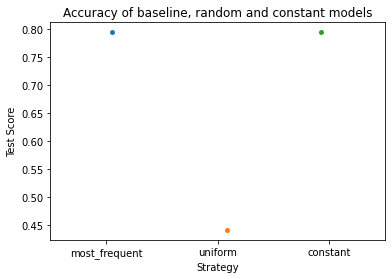

In [16]:
from sklearn.dummy import DummyClassifier

strategies = ['most_frequent', 'uniform', 'constant']
  
test_scores = []
for s in strategies:
    if s =='constant':
        dclf = DummyClassifier(strategy = s, random_state = 42, constant = 0)
    else:
        dclf = DummyClassifier(strategy = s, random_state = 42)
    dclf.fit(X_train, y_train)
    score = dclf.score(X_test, y_test)
    test_scores.append(score)
test_scores

ax = sns.stripplot(strategies, test_scores);
ax.set(xlabel ='Strategy', ylabel ='Test Score', title='Accuracy of baseline, random and constant models')
plt.show()

The rule-based model predicts the most frequent class of the target variable ( that is 0), the constant model predicts 0 every time which is same as the  rule-based model. The uniform model randomly predicts either class of the target variable on a 50:50 basis. 
In terms of accuracy, the uniform model has the worst performance because there is class imbalance in the dataset whereas the rule-based and constant models perform better because they predict the most abundant class of the target variable.

/home/nnamdi/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


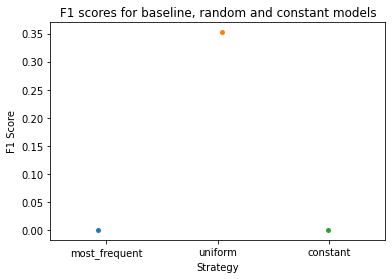

In [17]:
#### F1 scores

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

strategies = ['most_frequent', 'uniform', 'constant']
  
F1_scores = []
for s in strategies:
    if s =='constant':
        dclf = DummyClassifier(strategy = s, random_state = 42, constant = 0) # predicts 0 / non_Chinstrap every time
    else:
        dclf = DummyClassifier(strategy = s, random_state = 42)
    y_train_pred = cross_val_predict( dclf, X_train, y_train, cv=3)
    f1 = f1_score(y_train, y_train_pred)
    F1_scores.append(f1)
F1_scores

# plots of F1 scores
ax = sns.stripplot(strategies, F1_scores);
ax.set(xlabel ='Strategy', ylabel ='F1 Score', title='F1 scores for baseline, random and constant models')
plt.show()

### Preprocessing data for machine learning

In [18]:
### preprocess and transform training data
training_data = X_train.copy() # make a copy of the training data
training_labels = y_train.copy() # make a copy of the training label

### Pipeline for numerical variables
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('std_scaler', StandardScaler())])

### ColumnTransformer for training data set
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer 
num_attribs = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
cat_attribs = ["island","sex"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs)])

X_train_tr = full_pipeline.fit_transform(training_data)  #the final training data excluding the labels

In [19]:
#### apply same transformation to test data 
test_data = X_test.copy()
test_labels = y_test.copy()

### Pipeline for numerical variables
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('std_scaler', StandardScaler())])

### ColumnTransformer for training data set
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer 
num_attribs = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
cat_attribs = ["island","sex"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", OneHotEncoder(), cat_attribs)])

X_test_tr = full_pipeline.fit_transform(test_data) # the final test data , excluding the test labels

### Train and compare ML models

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# use these classifiers, without changing their settings
perceptron_clf = SGDClassifier(max_iter=100, loss='perceptron', random_state=42)
tree_clf = DecisionTreeClassifier(max_features=2, max_depth=2, random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

In [21]:
from sklearn.model_selection import cross_val_score
CV_score_perceptron = cross_val_score(perceptron_clf, X_train_tr, training_labels, cv=3, scoring="accuracy", verbose=5)
CV_score_tree = cross_val_score(tree_clf, X_train_tr, training_labels, cv=3, scoring="accuracy", verbose=5)
CV_score_ADA = cross_val_score(ada_clf, X_train_tr, training_labels, cv=3, scoring="accuracy", verbose=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

[CV] END ................................ score: (test=0.990) total time=   0.0s
[CV] END ................................ score: (test=0.990) total time=   0.0s
[CV] END ................................ score: (test=0.970) total time=   0.0s
[CV] END ................................ score: (test=0.808) total time=   0.0s
[CV] END ................................ score: (test=0.737) total time=   0.0s
[CV] END ................................ score: (test=0.798) total time=   0.0s
[CV] END ................................ score: (test=0.990) total time=   0.1s
[CV] END ................................ score: (test=1.000) total time=   0.1s
[CV] END ................................ score: (test=0.980) total time=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


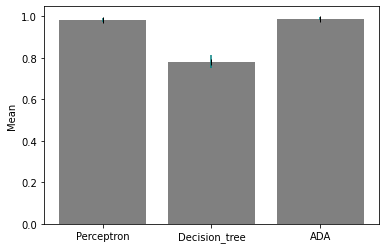

,Mean,Std
Perceptron,0.9832,0.0095
Decision_tree,0.7811,0.0312
ADA,0.9899,0.0082


In [22]:
### codes to generate a plot comparing the CV scores of the classifiers
# combine the name of the classifier and the scores into a dictionary
algo_score = [CV_score_perceptron,CV_score_tree,CV_score_ADA]
algo_names = ['Perceptron','Decision_tree','ADA']
dicts={}
values = []
for score in algo_score:
    mean = round(score.mean(),4)
    std = round(score.std(),4)
    values.append((mean, std))
for i in range(len(algo_names)):
    dicts[algo_names[i]] = values[i]

# convert the dictionary to a pandas dataframe, then generate a plot
df_CV_scores = pd.DataFrame.from_dict(dicts, orient='index', columns=['Mean','Std'])
x = df_CV_scores.index
y = df_CV_scores['Mean']
e = df_CV_scores['Std'] # standard deviation
plt.bar(x,y, color="grey")  # plots the mean
plt.ylabel("Mean")
plt.errorbar(x, y, yerr=e, fmt='o',ecolor = 'teal',color='black',marker = "|") # plots the standard deviation
plt.show()
df_CV_scores # prints the data frame

The ADA classifier had the best performance of 99% accuracy which is better than the 44% accuracy of the baseline model. 

### Error analysis

In [24]:
# Use cross validation to generate predictions for plotting the confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(ada_clf, X_train_tr, training_labels, cv=3)

# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(training_labels, y_train_pred)

array([[237,   1],
       [  2,  57]])

In [25]:
## Calculate the true positive rate(TPR) and true negative rate (TNR) of the ADA classifier
TP = 57
FP = 1
FN = 2
TN = 237

TPR = round((TP/(TP+FN))*100,2)
print("TPR of the ADA classifier is "+str(TPR)+'%')
TNR = round((TN/(FP+TN))*100,2)
print("TNR of the ADA classifier is "+str(TNR)+'%')

TPR of the ADA classifier is 96.61%
TNR of the ADA classifier is 99.58%


In [26]:
from sklearn.metrics import precision_score, recall_score
print("precision score of the Perceptron classifier is: ",precision_score(training_labels, y_train_pred)) # accuracy of positive predictions
print("recall score of the Perceptron classifier is: ",recall_score(training_labels, y_train_pred))

precision score of the Perceptron classifier is:  0.9827586206896551
recall score of the Perceptron classifier is:  0.9661016949152542
